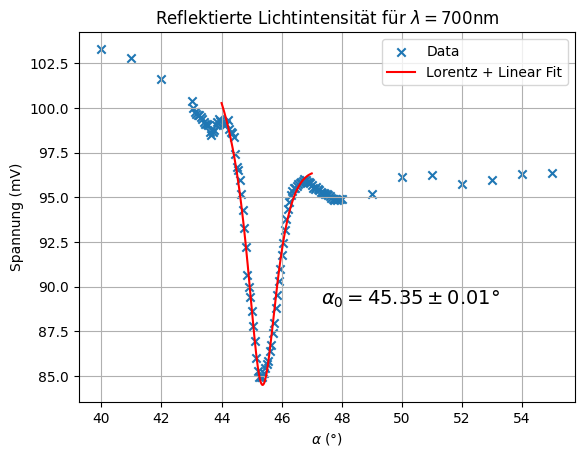

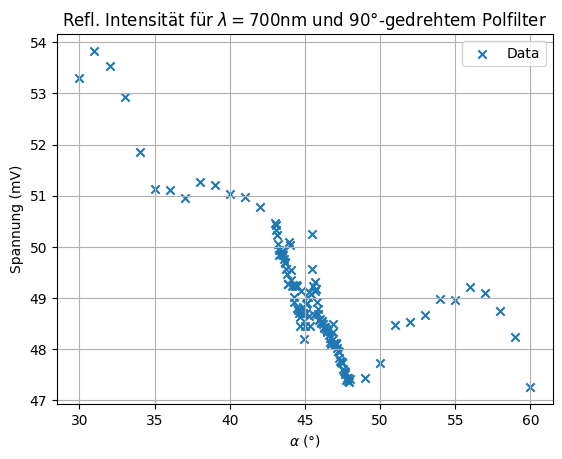

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy.optimize import curve_fit

data_folder = 'Data'
file_paths = glob.glob(f'{data_folder}/*')

def wavelength_key(path):
    filename = os.path.basename(path)
    return int(filename.split('nm')[0])
    
peak_roi = {
    450: (46,53),
    500: (44,50),
    550: (44,49),
    600: (44,48),
    650: (44,48),
    700: (44,47),
    750: (44,47),
    800: (44,46),
    850: (44,46),
    900: (44,46),
    950: (44,46),
    1000: (44,46)
}

def lorentz_linear(x, a, x0, gamma, b, c):
    return a / (1 + ((x - x0) / gamma) ** 2) + b * x + c

wavelengths = []
x0_vals = []
x0_errs = []
for path in sorted(file_paths, key=wavelength_key):
    data = np.loadtxt(path)
    alpha, voltages = data[:, 0], data[:, 1]
    mask = (alpha >= 40) & (alpha <= 55)
    alpha = alpha[mask]
    voltages = voltages[mask]
    filename = os.path.basename(path)

    wavelength = wavelength_key(path)
    if wavelength not in peak_roi:
        continue

    roi_min, roi_max = peak_roi[wavelength]
    mask = (alpha >= roi_min) & (alpha <= roi_max)
    x_fit = alpha[mask]
    y_fit = voltages[mask]

    if len(x_fit) < 5:
        continue

    a_init = -5
    x0_init = x_fit[np.argmin(y_fit)]
    gamma_init = 1
    b_init = 0
    c_init = np.median(y_fit)

    popt, pcov = curve_fit(lorentz_linear, x_fit, y_fit, p0=[a_init, x0_init, gamma_init, b_init, c_init])
    x0_vals.append(popt[1])
    wavelengths.append(wavelength)
    x0_errs.append(np.sqrt(pcov[1, 1]))

    x_plot = np.linspace(min(x_fit), max(x_fit), 300)
    y_plot = lorentz_linear(x_plot, *popt)

    if wavelength == 700:
        plt.figure()
        plt.scatter(alpha, voltages, label='Data', marker='x')
        plt.plot(x_plot, y_plot, label='Lorentz + Linear Fit', color='r')
        plt.title(rf"Reflektierte Lichtintensität für $\lambda={wavelength}$nm")
        # Add text with alpha_0 and error to the bottom right
        plt.text(0.85, 0.25, rf"$\alpha_0 = {popt[1]:.2f} \pm {np.sqrt(pcov[1, 1]):.2f}$°", 
                transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=14)
        plt.xlabel(r'$\alpha$ (°)')
        plt.ylabel('Spannung (mV)')
        plt.grid(True)
        plt.legend()
        plt.show()

        control_data_path = 'OldData/700nm_90grad'
        
        control_data = np.loadtxt(control_data_path)
        control_alpha, control_voltages = control_data[:, 0], control_data[:, 1]
        mask = (control_alpha >= 30) & (control_alpha <= 65)

        plt.figure()
        plt.scatter(control_alpha[mask], control_voltages[mask], label='Data', marker='x')
        plt.title(rf"Refl. Intensität für $\lambda={wavelength}$nm und 90°-gedrehtem Polfilter")
        plt.xlabel(r'$\alpha$ (°)')
        plt.ylabel('Spannung (mV)')
        plt.grid(True)
        plt.legend()
        plt.show()


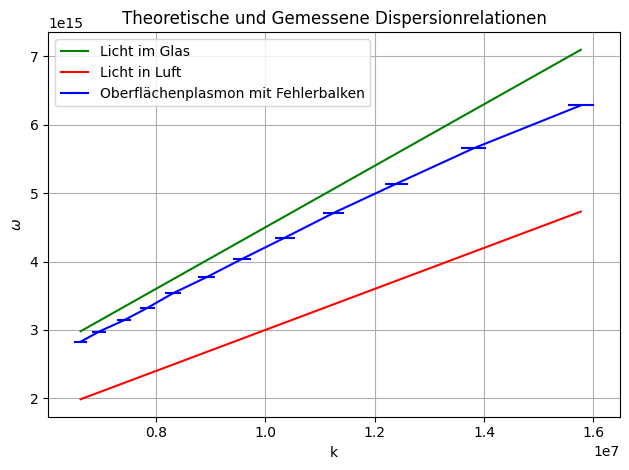

In [28]:
alpha = np.array(x0_vals)
alpha_err_fit = np.array(x0_errs)
alpha_err_goniometer = np.ones_like(alpha)
alpa_err = np.sqrt(alpha_err_fit**2 + alpha_err_goniometer**2)
wavelength = np.array(wavelengths) * 1e-9  # Convert nm to meters
wavelength_err = np.ones_like(wavelength) * 1e-9 * 0.6
k = 1.5 * 2 * np.pi / wavelength
k_err = 1.5 * 2 * np.pi * wavelength_err / (wavelength ** 2)
c = 3e8
omega = k * c 
alpha_rad = np.radians(alpha)
k_oberfl = k * np.sin(alpha_rad)
k_oberfl_err = np.sqrt((k_err * np.sin(alpha_rad))**2 + (k * np.cos(alpha_rad) * np.radians(alpa_err))**2)
k_light = np.linspace(min(k_oberfl), max(k_oberfl), 100)
omega_air = c * k_light
omega_glass = 1.5 * c * k_light

plt.figure()
plt.rcParams.update({'font.size': 10})
#plt.plot(k_oberfl, omega, label='Oberflächenplasmon', marker='o')
plt.title('Theoretische und Gemessene Dispersionrelationen')
plt.plot(k_light, omega_glass, label='Licht im Glas', color='green')
plt.plot(k_light, omega_air, label='Licht in Luft', color='red')
plt.errorbar(k_oberfl, omega, xerr=k_oberfl_err, label='Oberflächenplasmon mit Fehlerbalken', color='blue')
plt.xlabel("k")
plt.ylabel(r'$\omega$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

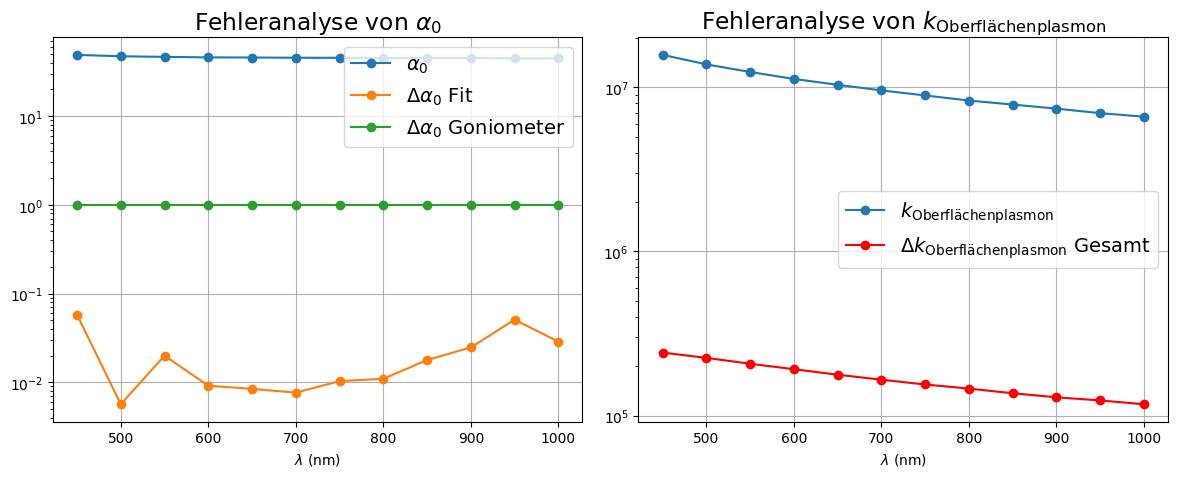

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plt.rcParams.update({'font.size': 14})

axs[0].set_title(r'Fehleranalyse von $\alpha_0$')
axs[0].plot(wavelengths, alpha, label=r'$\alpha_0$', marker='o')
axs[0].plot(wavelengths, alpha_err_fit, label=r'$\Delta \alpha_0$ Fit', marker='o')
axs[0].plot(wavelengths, alpha_err_goniometer, label=r'$\Delta \alpha_0$ Goniometer', marker='o')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$\lambda$ (nm)')
axs[0].legend(loc='upper right')
axs[0].grid(True)

axs[1].set_title(r'Fehleranalyse von $k_{\text{Oberflächenplasmon}}$')
axs[1].plot(wavelengths, k_oberfl, label=r'$k_{\text{Oberflächenplasmon}}$', marker='o')
axs[1].plot(wavelengths, k_oberfl_err, label=r'$\Delta k_{\text{Oberflächenplasmon}}$ Gesamt', marker='o', color='red')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\lambda$ (nm)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [34]:
import pandas as pd

f = c / wavelength
f_err = c * wavelength_err / (wavelength ** 2)

data = {
    'Wavelength (nm)': wavelengths,
    'alpha': alpha,
    'k Oberflächenplasmon': k_oberfl,
    'k Oberflächenplasmon Error': k_oberfl_err,
    'Frequency (Hz)': f,
    'Frequency Error (Hz)': f_err,
}
df = pd.DataFrame(data)
df

,Wavelength (nm),alpha,k Oberflächenplasmon,k Oberflächenplasmon Error,Frequency (Hz),Frequency Error (Hz)
0,450,48.843110,1.576892e+07,241888.094096,6.666667e+14,8.888889e+11
1,500,47.091157,1.380613e+07,224600.837799,6.000000e+14,7.200000e+11
2,550,46.374959,1.240421e+07,206829.529987,5.454545e+14,5.950413e+11
3,600,45.757177,1.125302e+07,191617.344479,5.000000e+14,5.000000e+11
4,650,45.601968,1.035996e+07,177319.689423,4.615385e+14,4.260355e+11
5,700,45.345791,9.577748e+06,165366.316063,4.285714e+14,3.673469e+11
6,750,45.242815,8.923343e+06,154600.351036,4.000000e+14,3.200000e+11
7,800,44.842707,8.307505e+06,145933.419163,3.750000e+14,2.812500e+11
8,850,45.101967,7.854322e+06,136730.861425,3.529412e+14,2.491349e+11
9,900,45.083028,7.415528e+06,129184.919142,3.333333e+14,2.222222e+11
